# Cross validation with `scikit-learn`

This example shows how `pykoop` works with `scikit-learn` to allow cross-validation over all parameters in the Koopman pipeline.

In [1]:
# Imports
import numpy as np
import pandas
import sklearn.model_selection
import sklearn.preprocessing
from matplotlib import pyplot as plt

import pykoop
import pykoop.dynamic_models

# Set plot defaults
plt.rc('lines', linewidth=2)
plt.rc('axes', grid=True)
plt.rc('grid', linestyle='--')

Load example data from the library. `eg` is a `dict` containing training data, validation data, and a few related parameters.

In [2]:
eg = pykoop.example_data_msd()

Create the Koopman pipeline. We don't need to set any lifting functions since they'll be set during the cross-validation.

In [3]:
kp = pykoop.KoopmanPipeline(regressor=pykoop.Edmd())

Set up the cross-validation splitting. Here we use the episode feature to ensure that the split keeps individual experiments intact.

In [4]:
episode_feature = eg['X_train'][:, 0]
cv = sklearn.model_selection.GroupShuffleSplit(
    random_state=1234,
    n_splits=3,
).split(eg['X_train'], groups=episode_feature)

Choose the cross-validation parameters. We can cross-validate over entire lifting functions, or just specific regressor or lifting function parameters using the `scikit-learn` parameter setting conventions.

In [5]:
params = {
    # Lifting functions to try
    'lifting_functions': [
        [(
            'ss',
            pykoop.SkLearnLiftingFn(
                sklearn.preprocessing.StandardScaler()),
        )],
        [
            (
                'ma',
                pykoop.SkLearnLiftingFn(
                    sklearn.preprocessing.MaxAbsScaler()),
            ),
            (
                'pl',
                pykoop.PolynomialLiftingFn(order=2),
            ),
            (
                'ss',
                pykoop.SkLearnLiftingFn(
                    sklearn.preprocessing.StandardScaler()),
            ),
        ],
    ],
    # Regressor parameters to try
    'regressor__alpha': [0, 0.1, 1, 10],
}

Set up the grid search cross-validation. We have multiple scoring metrics over different time windows, but we choose the "ten step ahead" prediction ranking and refitting.

In [6]:
gs = sklearn.model_selection.GridSearchCV(
    kp,
    params,
    cv=cv,
    # Score using short and long prediction time frames
    scoring={
        f'full_episode': pykoop.KoopmanPipeline.make_scorer(),
        f'ten_steps': pykoop.KoopmanPipeline.make_scorer(n_steps=10),
    },
    # Rank according to short time frame
    refit='ten_steps',
)

Perform the cross-valdiation and pick the winner.

In [7]:
gs.fit(
    eg['X_train'],
    n_inputs=eg['n_inputs'],
    episode_feature=eg['episode_feature'],
)
best_estimator = gs.best_estimator_

This is the matrix approximation of the Koopman operator. It needs to be transposed because `scikit-learn` puts time on the first axis and features on the second.

In [8]:
best_estimator.regressor_.coef_.T

array([[ 9.91883440e-01,  8.94273868e-02,  1.79097934e-04,
        -3.13640303e-04, -2.95548469e-03,  9.70314627e-03,
        -9.98717276e-05,  4.42764949e-03, -1.60312780e-03],
       [-1.43815421e-01,  8.73130869e-01, -7.37399270e-04,
        -5.08492758e-03, -8.62861954e-03,  1.48763701e-01,
         4.77555077e-03,  1.52077930e-02, -7.06918061e-03],
       [ 2.31449054e-04,  4.66948082e-06,  9.82608512e-01,
         1.41282965e-01,  9.42406644e-03,  8.19992260e-05,
         1.93299275e-02,  1.27826191e-03, -1.11644849e-03],
       [-1.77900783e-04, -1.75636014e-03, -1.76376390e-01,
         8.48278785e-01,  9.60773702e-02,  1.96343500e-03,
         1.43159804e-01,  3.21235551e-02, -2.91522952e-03],
       [ 4.36902662e-04,  1.68738238e-03,  2.18075712e-02,
        -1.93181000e-01,  7.61323258e-01, -2.19676979e-03,
        -3.54741406e-02,  2.35737972e-01,  1.35329508e-02]])

These are the cross-validation results summarized in a big table. Scores are negated mean squared errors.

In [9]:
pandas.DataFrame(gs.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_lifting_functions,param_regressor__alpha,params,split0_test_full_episode,split1_test_full_episode,split2_test_full_episode,mean_test_full_episode,std_test_full_episode,rank_test_full_episode,split0_test_ten_steps,split1_test_ten_steps,split2_test_ten_steps,mean_test_ten_steps,std_test_ten_steps,rank_test_ten_steps
0,0.002129,0.001062,0.094716,0.012392,"[(ss, SkLearnLiftingFn(transformer=StandardSca...",0,"{'lifting_functions': [('ss', SkLearnLiftingFn...",-0.000396,-0.000421,-0.000683,-0.000500,0.000130,4,-0.000142,-0.000153,-0.000406,-0.000233,0.000122,3
1,0.001522,0.000390,0.096214,0.015442,"[(ss, SkLearnLiftingFn(transformer=StandardSca...",0.1,"{'lifting_functions': [('ss', SkLearnLiftingFn...",-0.000427,-0.000373,-0.000653,-0.000485,0.000121,2,-0.000138,-0.000110,-0.000361,-0.000203,0.000112,2
2,0.001714,0.000255,0.094566,0.005554,"[(ss, SkLearnLiftingFn(transformer=StandardSca...",1,"{'lifting_functions': [('ss', SkLearnLiftingFn...",-0.000745,-0.000440,-0.000645,-0.000610,0.000127,5,-0.000140,-0.000507,-0.000124,-0.000257,0.000177,4
3,0.001659,0.000584,0.089189,0.012520,"[(ss, SkLearnLiftingFn(transformer=StandardSca...",10,"{'lifting_functions': [('ss', SkLearnLiftingFn...",-0.001322,-0.004338,-0.003608,-0.003089,0.001285,7,-0.000290,-0.003897,-0.000205,-0.001464,0.001721,7
4,0.002978,0.000635,0.185943,0.011038,"[(ma, SkLearnLiftingFn(transformer=MaxAbsScale...",0,"{'lifting_functions': [('ma', SkLearnLiftingFn...",-0.000314,-0.000411,-0.000644,-0.000456,0.000138,1,-0.000230,-0.000217,-0.000369,-0.000272,0.000069,5
5,0.003803,0.001685,0.240437,0.058409,"[(ma, SkLearnLiftingFn(transformer=MaxAbsScale...",0.1,"{'lifting_functions': [('ma', SkLearnLiftingFn...",-0.000467,-0.000384,-0.000628,-0.000493,0.000101,3,-0.000199,-0.000166,-0.000120,-0.000162,0.000032,1
6,0.003041,0.000620,0.240746,0.083650,"[(ma, SkLearnLiftingFn(transformer=MaxAbsScale...",1,"{'lifting_functions': [('ma', SkLearnLiftingFn...",-0.002445,-0.001038,-0.002982,-0.002155,0.000819,6,-0.000429,-0.003733,-0.000212,-0.001458,0.001611,6
7,0.005639,0.002675,0.237306,0.016316,"[(ma, SkLearnLiftingFn(transformer=MaxAbsScale...",10,"{'lifting_functions': [('ma', SkLearnLiftingFn...",-0.004469,-0.004848,-0.003980,-0.004432,0.000355,8,-0.001622,-0.007135,-0.000664,-0.003140,0.002852,8


This was the winner

In [10]:
best_estimator

KoopmanPipeline(lifting_functions=[('ma',
                                    SkLearnLiftingFn(transformer=MaxAbsScaler())),
                                   ('pl', PolynomialLiftingFn(order=2)),
                                   ('ss',
                                    SkLearnLiftingFn(transformer=StandardScaler()))],
                regressor=Edmd(alpha=0.1))

Predict a new trajectory using the best pipeline.

In [11]:
X_pred = best_estimator.predict_trajectory(eg['x0_valid'], eg['u_valid'])

Score a new trajectory using the best pipeline.

In [12]:
score = best_estimator.score(eg['X_valid'])

Plot the prediction

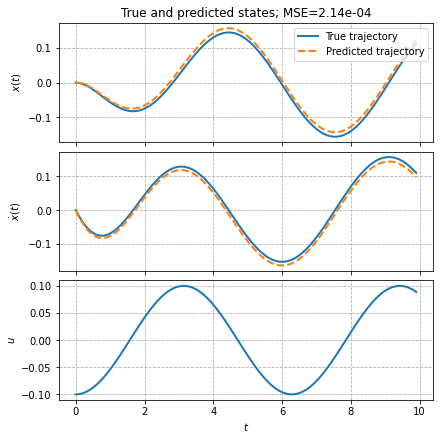

In [13]:
fig, ax = plt.subplots(
    best_estimator.n_states_in_ + best_estimator.n_inputs_in_,
    1,
    constrained_layout=True,
    sharex=True,
    figsize=(6, 6),
)
# Plot true trajectory
ax[0].plot(eg['t'], eg['X_valid'][:, 1], label='True trajectory')
ax[1].plot(eg['t'], eg['X_valid'][:, 2])
ax[2].plot(eg['t'], eg['X_valid'][:, 3])
# Plot predicted trajectory
ax[0].plot(eg['t'], X_pred[:, 1], '--', label='Predicted trajectory')
ax[1].plot(eg['t'], X_pred[:, 2], '--')
# Add labels
ax[-1].set_xlabel('$t$')
ax[0].set_ylabel('$x(t)$')
ax[1].set_ylabel(r'$\dot{x}(t)$')
ax[2].set_ylabel('$u$')
ax[0].set_title(f'True and predicted states; MSE={-1 * score:.2e}')
ax[0].legend(loc='upper right')